# Goal: Implement a Logistic Regression on Hemorrhage Data

In [218]:
#Import Modules
import numpy as np
import os
import pydicom
import cv2
import matplotlib.pyplot as plt
import csv
import pandas as pd
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import seaborn as sns
#from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [219]:
#Import all of the labeling data into a Pandas Dataframe
train = pd.read_csv("H:/CS230_Project/CS-230-Hemorrhage/rsna-intracranial-hemorrhage-detection/stage_1_train.csv")

In [220]:
#Check to make sure the data was imported correctly
train.head(20)

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0
6,ID_2669954a7_epidural,0
7,ID_2669954a7_intraparenchymal,0
8,ID_2669954a7_intraventricular,0
9,ID_2669954a7_subarachnoid,0


0    3814760
1     230812
Name: Label, dtype: int64


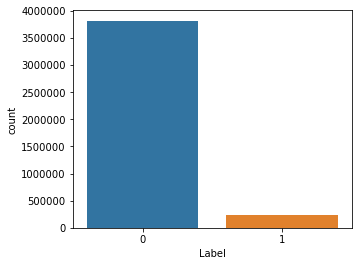

In [221]:
#bar chart of labels with 0 compared to labels with 1 (Hemorrhage)
sns.countplot(train.Label)
print (train.Label.value_counts())

In [222]:
#Copy Train Dataframe to do more analysis on:
Train2 = train.copy()
#Convert table into subtypes 
Train2['Sub_type'] = Train2['ID'].str.split("_", n = 3, expand = True)[2]
Train2['ImageID'] = Train2['ID'].str.split("_", n = 3, expand = True)[1]
Train2.head()

,ID,Label,Sub_type,ImageID
0,ID_63eb1e259_epidural,0,epidural,63eb1e259
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,63eb1e259
2,ID_63eb1e259_intraventricular,0,intraventricular,63eb1e259
3,ID_63eb1e259_subarachnoid,0,subarachnoid,63eb1e259
4,ID_63eb1e259_subdural,0,subdural,63eb1e259


In [223]:
GB_Sub = Train2.groupby('Sub_type').sum()
GB_Sub

,Label
Sub_type,
any,97103
epidural,2761
intraparenchymal,32564
intraventricular,23766
subarachnoid,32122
subdural,42496


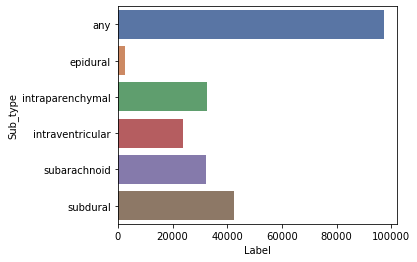

In [224]:
#Bar plot of differnt types of Hemorrhages in the dataset
sns.barplot(y=GB_Sub.index, x=GB_Sub.Label, palette="deep")

Text(0.5, 1.0, 'Total Images by Subtype')

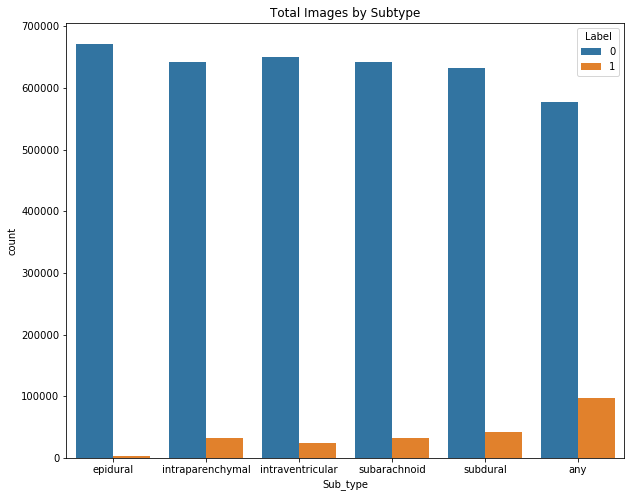

In [225]:
#Comparative Graph of each Hemorrhage with the ratio of 0s:1s
fig=plt.figure(figsize=(10, 8))
sns.countplot(x="Sub_type", hue="Label", data=Train2)
plt.title("Total Images by Subtype")

In [226]:
#Since each of our images has 6 labels, this should give us the number of images (It does)
int(train.shape[0]/6)

674262

In [227]:
#This Function takes in an image ID and it returns the flattened pixel data 
def open_image(image_ID):
    #Get image from source
    img_dir = "H:/CS230_Project/CS-230-Hemorrhage/rsna-intracranial-hemorrhage-detection/stage_1_train_images/" + image_ID + ".dcm"
    ds = pydicom.dcmread(img_dir)
    ds_array = ds.pixel_array
    
    ds_array = cv2.resize(ds_array, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
    image_flat = ds_array.reshape((1,ds_array.shape[0]*ds_array.shape[1]))

    return image_flat

In [228]:
#This Function takes in an image ID and it returns a plot of the image in 512 x 512
def view_image_512(image_ID):
    #Get image from source
    img_dir = "H:/CS230_Project/CS-230-Hemorrhage/rsna-intracranial-hemorrhage-detection/stage_1_train_images/" + image_ID + ".dcm"
    ds = pydicom.dcmread(img_dir)
    ds_array = ds.pixel_array
    plt.imshow(ds_array)

In [229]:
#This Function takes in an image ID and it returns a plot of the image in 128 x 128
def view_image_128(image_ID):
    #Get image from source
    img_dir = "H:/CS230_Project/CS-230-Hemorrhage/rsna-intracranial-hemorrhage-detection/stage_1_train_images/" + image_ID + ".dcm"
    ds = pydicom.dcmread(img_dir)
    ds_array = ds.pixel_array
    ds_array = cv2.resize(ds_array, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
    plt.imshow(ds_array)

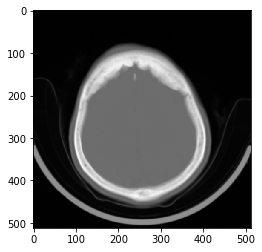

In [230]:
#Show an image in 512 x 512
view_image_512(image_ID="ID_63eb1e259")

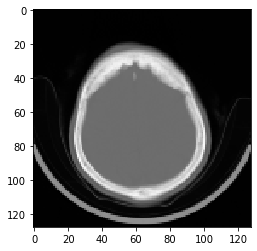

In [231]:
#Compare image to 128 x 128 to show that the level of detail is minimally changed, but compute cost is much lower
view_image_128(image_ID="ID_63eb1e259")

In [ ]:
#Build Dataset
#The goal of this function is to create a matched dataset of the X (image) data to the Y (0,1 Matrix) data
train_size = 2000   #This is the number of pictures we want to have in the training set

image_info = []   
old_id = ""
Y = np.empty([train_size,6])              #Initailize Y
X = np.empty([train_size,16384])          #Initailize X
Image_Names_Sorted = []
for i,row in train[:train_size*6].iterrows():
    image_ID = row["ID"][:12] #This gets the ID of the image from the full specification
    if (i==0):
        old_id = row["ID"][:12]
    if(image_ID ==old_id):
        image_info.append(int(row["Label"]))
    else:
        j = int((i)/6-1) #Since there are six classiffications this loop should only be entered every 6th iteration
        Y[j] = image_info
        X[j] = open_image(image_ID)
        Image_Names_Sorted.append(image_ID) 
        image_info = []
        image_info.append(int(row["Label"]))
        old_id = image_ID
    if (i==train_size*6-1):
        j = int((i+1)/6-1)
        Y[j] = image_info
        X[j] = open_image(image_ID)
        Image_Names_Sorted.append(image_ID)
    

In [ ]:
#Understanding our Dataset:
Y_sum = np.sum(Y,axis=1,keepdims = False) #This gives us an array where any sum > 0 inicates the presence of a hemorrhage
index1 = np.where(Y_sum > 0) #Now we spit the data set into "Contains Hemorrhage" (1) and does not (0)
index0 = np.where(Y_sum == 0)

In [ ]:
#Create spit datasets
#we spit the data set into "Contains Hemorrhage" (1) and does not (0)
X_1 = X[index1]
Y_1 = Y[index1]

X_0 = X[index0]
Y_0 = Y[index0]

X_0 = X_0[:X_1.shape[0]] #This allows us to pull a dataset of the same size of 0's as 1's
Y_0 = Y_0[:X_1.shape[0]]

In [ ]:
#Combine the dataset into a final X and Y set
X_Final = np.concatenate((X_1,X_0),axis=0)
Y_Final = np.concatenate((Y_1,Y_0),axis=0)

In [ ]:
print (Y_Final.shape) #Tells us how many images we are actually training on

In [ ]:
#Normalizing Inputs:
def normalize(X_prev):
    u = np.mean(X_prev)
    var = np.var(X_prev)
    X = (X_prev - u)/var
    return X

In [ ]:
#Normalize the X_Final data to help with optimization
X_Prep = normalize(X_Final)

In [ ]:
#Normalize the X1 data for testing
X_1_Test = normalize(X_1)

In [ ]:
# Splitting the Data into test and train:
train_x, test_x, train_y, test_y = train_test_split(X_Prep, Y_Final, test_size=0.3, random_state=42)

In [ ]:
train_x = train_x.T
test_x = test_x.T
train_y = train_y.T
test_y = test_y.T

In [ ]:
print (train_x.shape)
print (test_x.shape)
print (train_y.shape)
print (test_y.shape)

# Deep Neural Network:

In [ ]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [ ]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

In [ ]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [ ]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters):
   
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, "relu")
        caches.append(cache)
    
    A_prev = A 
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    AL, cache = linear_activation_forward(A_prev, W, b, "sigmoid")
    caches.append(cache)
            
    return AL, caches

In [ ]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
   
    m = Y.shape[1]
    cost = -(1/m)*np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

In [ ]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [ ]:
# GRADED FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
   
    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [ ]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [ ]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] += -learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] += -learning_rate*grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

In [ ]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 16384     # num_px * num_px * 3
n_h = 7
n_y = 6
layers_dims = (n_x, n_h, n_y)

In [ ]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [ ]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((6,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        for j in range(0, probas.shape[0]):
            if probas[j,i] > 0.5:
                p[j,i] = 1
            else:
                p[j,i] = 0
    
    print (np.sum(p,axis = 1))
    
    #print results
    print ("predictions: " + str(p))
    print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)/6))
        
    return p

In [ ]:
pred_train = predict(train_x, train_y, parameters)